In [1]:
# Author: Samantha Tetef
# Created: 12.11.20
# Title: Dat_to_Spectra

In [31]:
import warnings
warnings.filterwarnings("ignore")

import utils as u
from importlib import reload
# to reload utils, run:
# u = reload(u)

import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

In [3]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
 }

<IPython.core.display.Javascript object>

In [4]:
ROOTDIR = os.getcwd().replace('\\', '/')

CIDdir = f"{ROOTDIR}/ProcessedData/"

CIDS = np.array([int(f.replace('_xes.dat', '')) for f in os.listdir(CIDdir) if f.endswith('_xes.dat')])

XES_DATA = u.get_Data(CIDS, mode='xes')
XANES_DATA = u.get_Data(CIDS, mode='xanes')

In [5]:
xes = np.array(u.get_Property(XES_DATA, 'Spectra'))
XESenergy = xes[0,0,:]
XES = xes[:,1,:]

XES_SCALING = np.max(XES)
XES = XES / XES_SCALING

In [6]:
xanes = np.array(u.get_Property(XANES_DATA, 'Spectra'))
XANESenergy = xanes[0,0,:]
XANES = xanes[:,1,:]

XANES_SCALING = np.max(XANES)
XANES = XANES / XANES_SCALING

# The Dataset

In [7]:
def esnip(trans, emin, spectra):
    x,y = trans
    for i, e in enumerate(x):
        if e >= emin:
            break
    x = x[i:]
    y = y[i:]
    
    if x[-1] < 0:
        return x[:-1], y[:-1]
    
    return x, y/np.max(spectra)

In [8]:
# need 7540, 31215, 204482, 7881, 6535, 13138, 75806

2098.3897


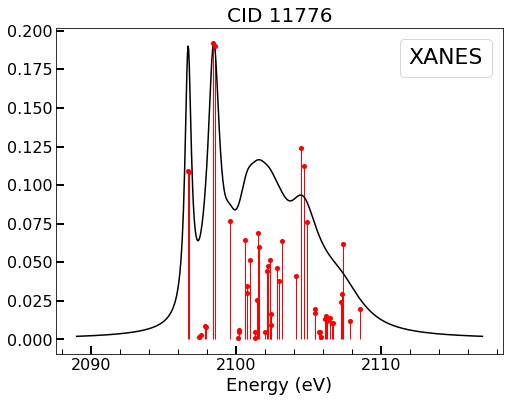

2101.3642


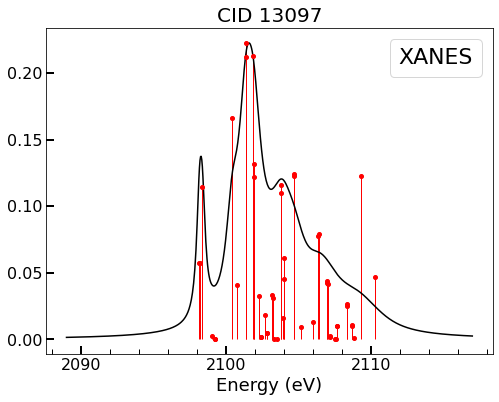

2102.8809


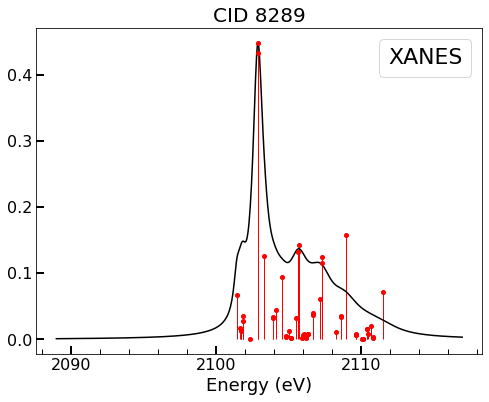

In [9]:
mycids = [11776, 13097, 8289]
for cid in mycids:
    
    i = np.where(CIDS==cid)[0][0]
    
    trans = XES_DATA[i]['Transitions']
    trans = esnip(trans, 2100, XES[i])
#     u.plot_spectrum_and_trans([XESenergy, XES[i]], trans, f'{CIDS[i]}', label='VtC-XES')
    
    trans = XANES_DATA[i]['Transitions']
    x, y = trans
    trans = x, y
    print(x[np.argmax(y)])
    u.plot_spectrum_and_trans([XANESenergy[100:-200], XANES[i][100:-200]], trans, f'{CIDS[i]}', label='XANES')

#     u.plot_spectrum([XESenergy, XES[i]], f'{CIDS[i]}', label='VtC-XES')
#     u.plot_spectrum([XANESenergy, XANES[i]], f'{CIDS[i]}', label='XANES')

In [10]:
df1 = pd.read_csv('Ph3P.csv')
df2 = pd.read_csv('Ph3PO.csv')
df3 = pd.read_csv('PhO3PO.csv')

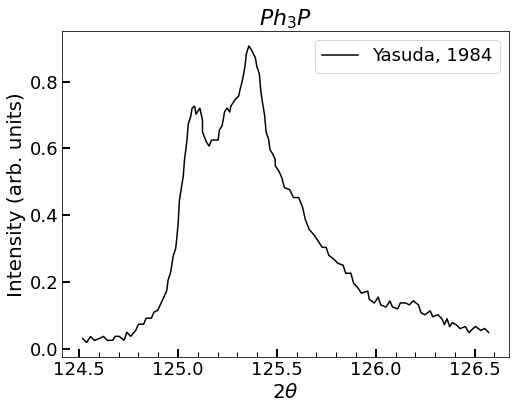

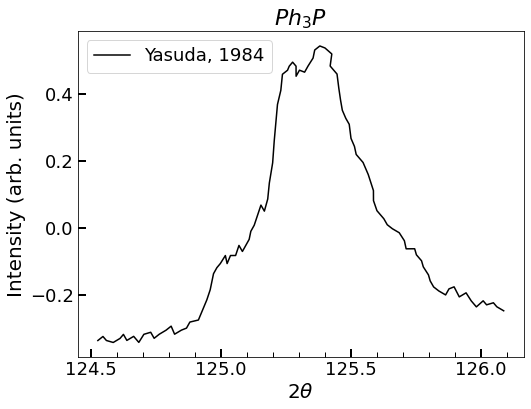

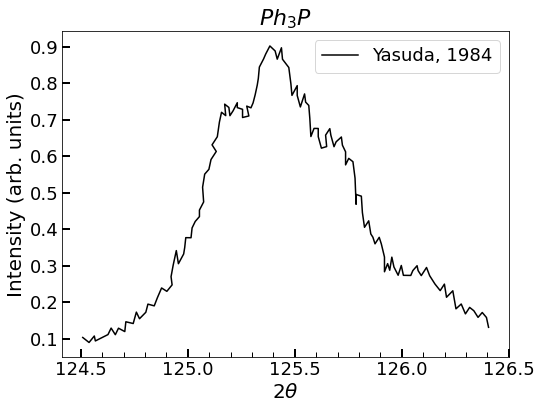

In [11]:
def plot_spectrum_vs_theta(df, title='$Ph_3P$'):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    df.plot(x='2theta', y='I', c='k', ax=ax, label='Yasuda, 1984')

    plt.title(title, fontsize=22)
    ax.set_ylabel("Intensity (arb. units)", fontsize=20)
    ax.set_xlabel(r"2$\theta$", fontsize=20)
    plt.tick_params(labelsize=18)

    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(direction='in', width=1, length=5, which='minor')
    ax.tick_params(direction='in', width=2, length=8, which='major')
    plt.legend(fontsize=18)
    plt.show()
    
plot_spectrum_vs_theta(df1)
plot_spectrum_vs_theta(df2)
plot_spectrum_vs_theta(df3)

In [12]:
hc = 1.23984193e-6 #ev/m
d = 6.5327e-10 #m
def to_energy(two_theta):
    return hc/(d*np.sin(two_theta*(np.pi/180)/2))

In [13]:
def plot_spectrum_from_df(df, title=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    x = to_energy(df['2theta'].values)
    y = df['I'].values
    y = y - np.min(y)
    y = y/np.max(y)
    plt.plot(x, y, 'k', label='Yasuda, 1984')

    plt.title(title, fontsize=22)
    ax.set_ylabel("Intensity (arb. units)", fontsize=20)
    ax.set_xlabel(r"Energy (eV)", fontsize=20)
    plt.tick_params(labelsize=18)

#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(direction='in', width=1, length=5, which='minor')
    ax.tick_params(direction='in', width=2, length=8, which='major')
    plt.legend(fontsize=18)
    plt.show()

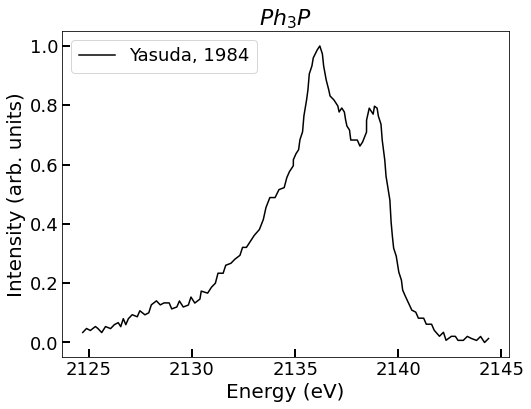

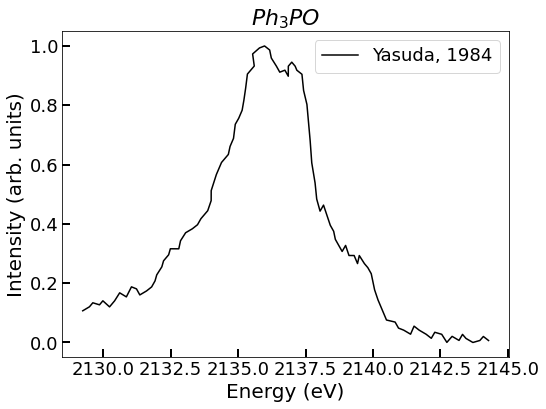

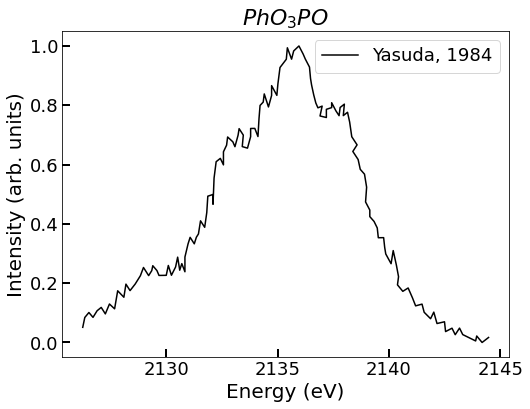

In [14]:
plot_spectrum_from_df(df1, title="$Ph_3P$")
plot_spectrum_from_df(df2, title="$Ph_3PO$")
plot_spectrum_from_df(df3, title="$PhO_3PO$")

In [15]:
def stack_plot(Spectrums, Labels, title=None,
               verbose=True, label=None, peaknorm=True):
    
    n = len(Spectrums)
    Colors=plt.cm.viridis(np.arange(n)/(n+1))
    if n == 2:
        Colors=['black', 'red']
    fig, ax = plt.subplots(figsize=(10,8))

    i = 0
    for spectrum in Spectrums:
        x, y = spectrum
        if peaknorm:
            y = y/np.max(y)
        ax.plot(x, y, '-', color=Colors[i], linewidth=2, label=Labels[i])
        i += 1

    if title is not None:
        plt.title(title, fontsize=20)
    plt.xlabel('Energy (eV)', fontsize=18)
    plt.tick_params(labelsize=16)

    if verbose:
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='in', width=1, length=5, which='minor')

    ax.tick_params(direction='in', width=2, length=8, which='major')

    plt.legend(fontsize=20)
    
    plt.show()

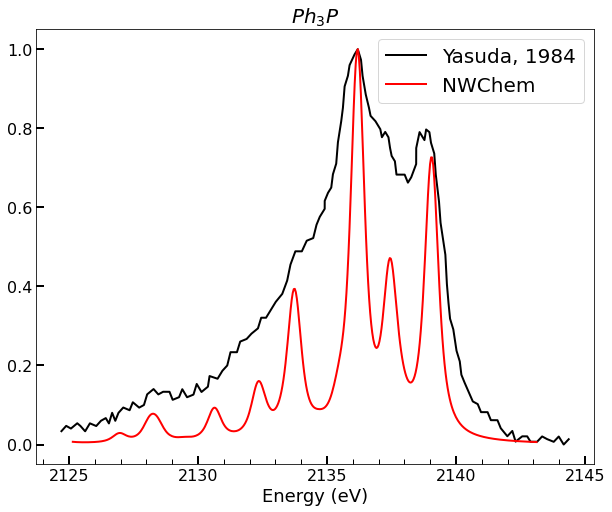

In [16]:
x = to_energy(df1['2theta'].values)
y = df1['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 350, 800
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[0])[0][0]
y2 = XES[i][emin:emax]
e_shift = x2[np.argmax(y2)] - x[np.argmax(y)]

stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$Ph_3P$")

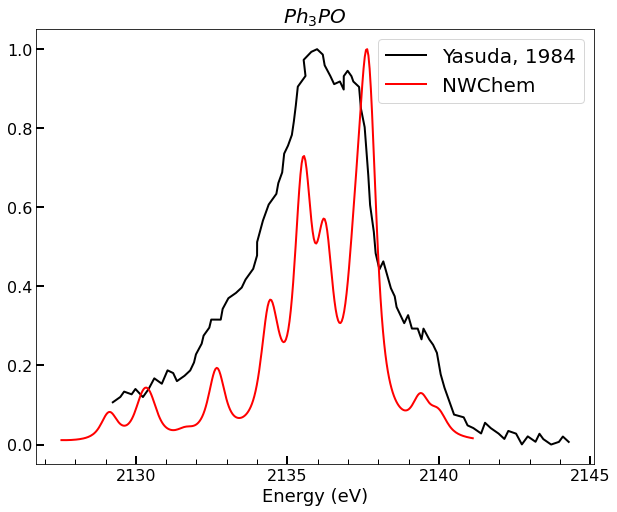

In [17]:
x = to_energy(df2['2theta'].values)
y = df2['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 410, 750
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[1])[0][0]
y2 = XES[i][emin:emax]

stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$Ph_3PO$", verbose=True)

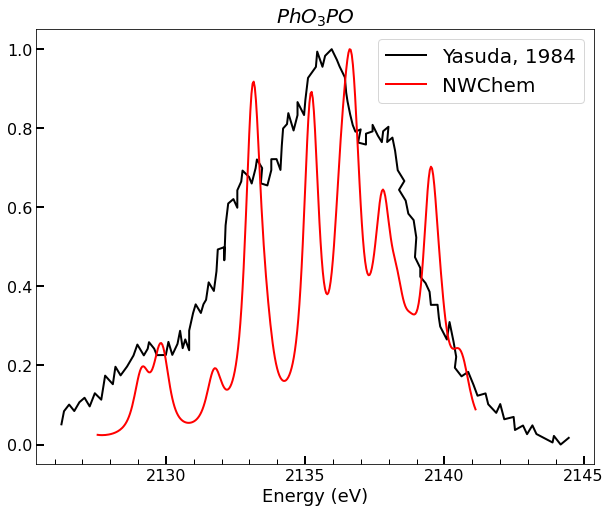

In [18]:
x = to_energy(df3['2theta'].values)
y = df3['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 410, 750
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[2])[0][0]
y2 = XES[i][emin:emax]

stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$PhO_3PO$", verbose=True)

In [19]:
print(e_shift)

18.870893736869675


# ML and Data Science section

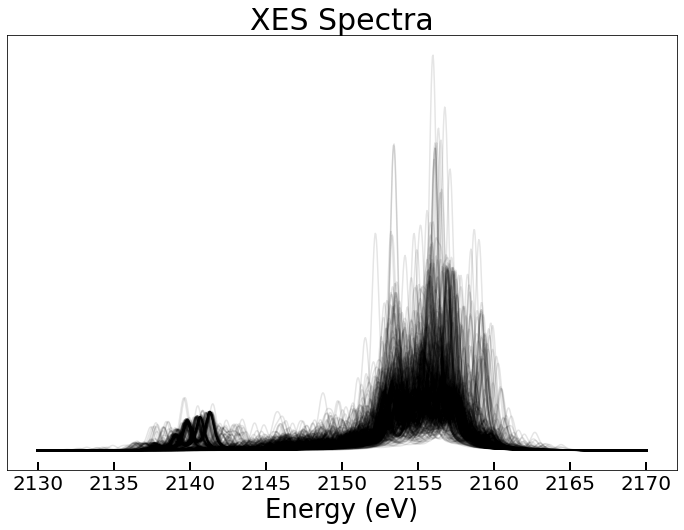

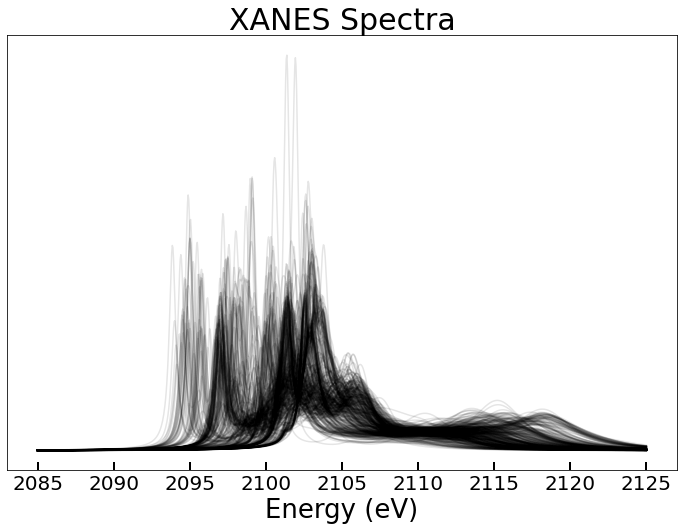

In [20]:
def Spagetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for x in X:
        plt.plot(energy, x, '-', c='k', alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Spagetti_plot(XESenergy, XES, mode='XES')
Spagetti_plot(XANESenergy, XANES, mode='XANES')

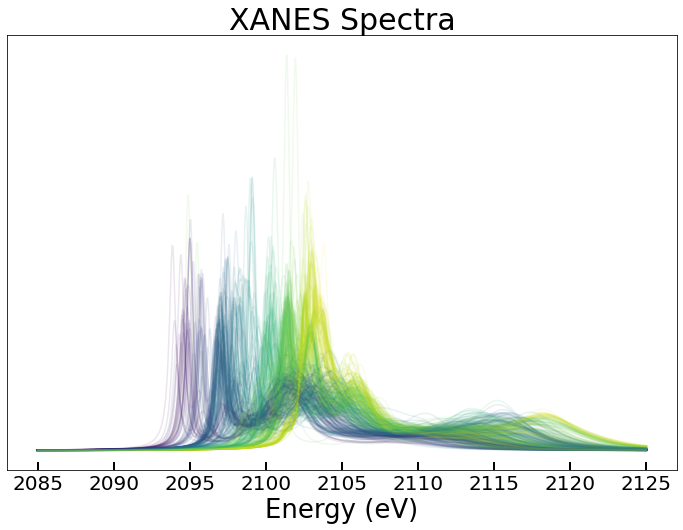

In [21]:
def Rainbow_spagetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    min_whiteline, max_whiteline = 500, 0
    for x in X:
        whiteline_idx = np.argmax(x)
        if whiteline_idx < min_whiteline:
            min_whiteline = whiteline_idx
        if whiteline_idx > max_whiteline:
            max_whiteline = whiteline_idx
    total_idx_range = max_whiteline - min_whiteline
    
    for x in X:
        whiteline_idx = np.argmax(x)
        scale = (whiteline_idx - min_whiteline)/total_idx_range
        plt.plot(energy, x, '-', color=plt.cm.viridis(scale), alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Rainbow_spagetti_plot(XANESenergy, XANES, mode='XANES')

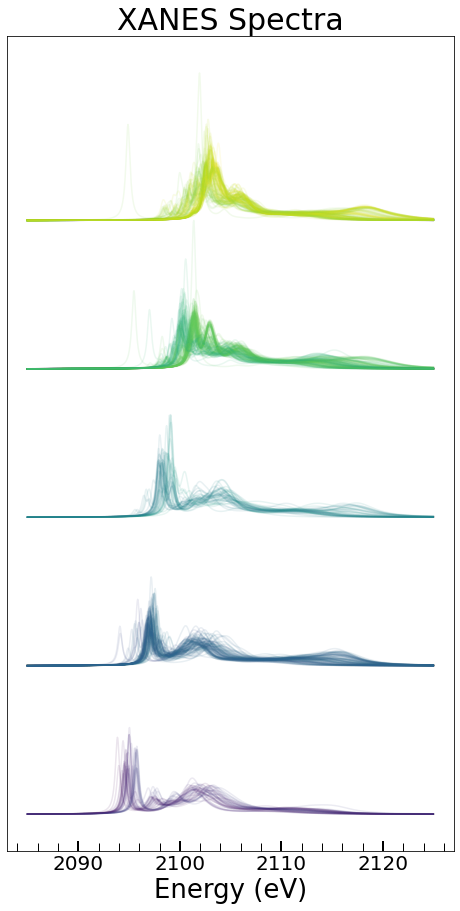

In [22]:
def Rainbow_spagetti_plot_stack(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    mn, mx = MINIMAX
    
    fig, ax = plt.subplots(figsize=(8,15))
    
    min_whiteline, max_whiteline = 500, 0
    for x in X:
        whiteline_idx = np.argmax(x)
        if whiteline_idx < min_whiteline:
            min_whiteline = whiteline_idx
        if whiteline_idx > max_whiteline:
            max_whiteline = whiteline_idx
    total_idx_range = max_whiteline - min_whiteline
    
    for x in X:
        whiteline_idx = np.argmax(x)
        scale = (whiteline_idx - min_whiteline)/total_idx_range
        bin_num = int(scale*10)//2
        if bin_num == 5:
            bin_num = 4
        plt.plot(energy[mn:mx], x[mn:mx] + bin_num, '-', color=plt.cm.viridis(scale), alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    ax.tick_params(direction='in', width=2, length=8)
    plt.xticks(fontsize=20)
    
    if mode == 'XANES':
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(10))
    
    ax.tick_params(direction='in', width=2, length=10, which='major')
    ax.tick_params(direction='in', width=1, length=8, which='minor')
    plt.yticks([])

    plt.show()
    
Rainbow_spagetti_plot_stack(XANESenergy, XANES, mode='XANES')

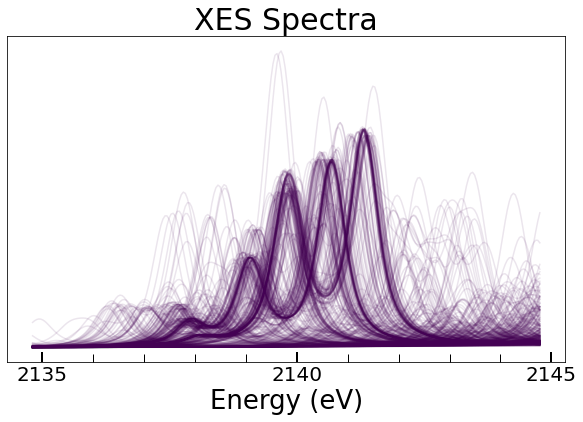

In [23]:
def Rainbow_spagetti_plot_stack2(energy, X, mode='XES', MINIMAX=[0,-1], figsize=(8,15)):
    
    mn, mx = MINIMAX
    
    fig, ax = plt.subplots(figsize=figsize)
    
    min_height, max_height = 1, 0
    for x in X:
        x = x[mn:mx]
        ligand_peak_height = np.max(x)
        if ligand_peak_height < min_height:
            min_height = ligand_peak_height
        if ligand_peak_height > max_height:
            max_height = ligand_peak_height
    total_range = max_height - min_height
    
    num_bins = 2
    
    for x in X:
        ligand_peak_height = np.max(x)
        scale = (ligand_peak_height - min_height)/total_range
        bin_num = 0 # int(scale//num_bins)
        if bin_num >= 3:
            bin_num = 2
        plt.plot(energy[mn:mx], x[mn:mx] + bin_num*0.3, '-', color=plt.cm.viridis(bin_num/num_bins), alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.tick_params(direction='in', width=2, length=10, which='major')
    ax.tick_params(direction='in', width=1, length=8, which='minor')
    plt.yticks([])

    plt.show()

Rainbow_spagetti_plot_stack2(XESenergy, XES, mode='XES', MINIMAX=[120, 370], figsize=(10,6))

In [32]:
warnings.filterwarnings("ignore")
# pca
pca1 = PCA(n_components=2)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=2)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=10)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=10, random_state=30)
XANES_TSNE = tsne.fit_transform(XANES)

In [25]:
def plot_dim_red(X_red, method, fontsize=16, mode='VtC-XES'):

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    
    plt.scatter(X_red[:, 0], X_red[:, 1], c='k')
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"{method} [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"{method} [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    legend = ax.legend([f'{mode}:\n{method}'], handlelength=0, handletextpad=0,
                           fancybox=True, fontsize=22)
    for item in legend.legendHandles:
        item.set_visible(False)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

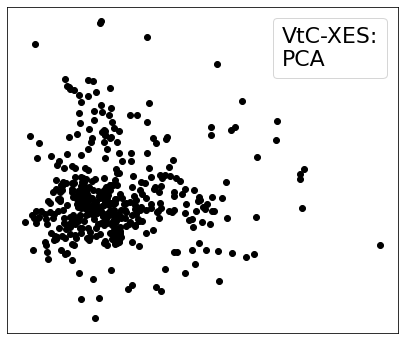

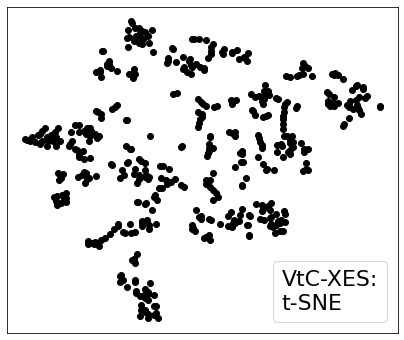

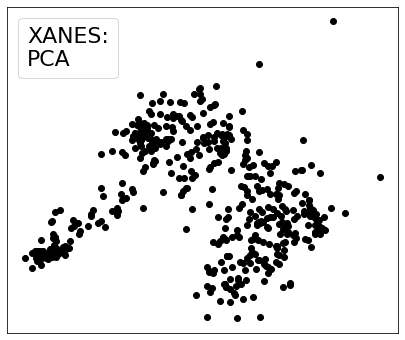

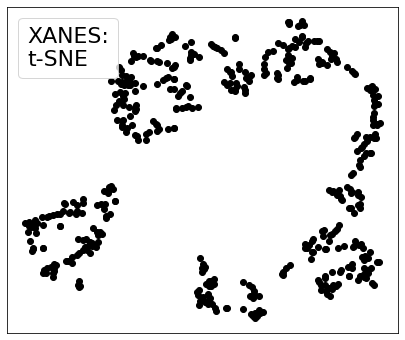

In [26]:
plot_dim_red(XES_PCA,'PCA')
plot_dim_red(XES_TSNE,'t-SNE')
plot_dim_red(XANES_PCA,'PCA', mode='XANES')
plot_dim_red(XANES_TSNE,'t-SNE', mode='XANES')

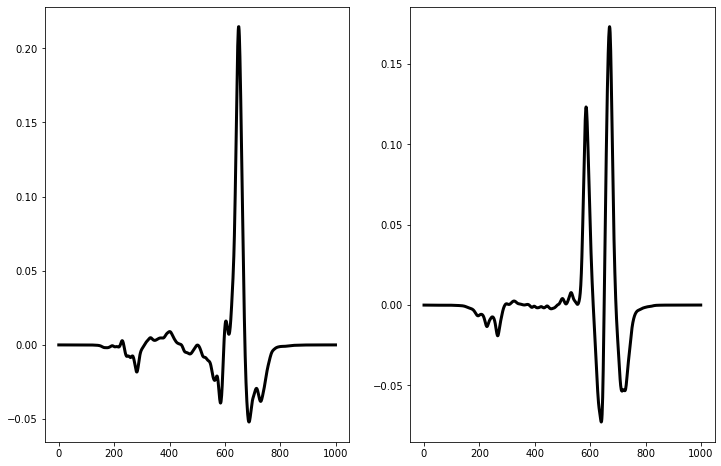

In [27]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

pcs = pca1.components_

for ax, pc in zip(axes, pcs):
    x = np.arange(len(pc))
    ax.plot(x, pc, 'k', linewidth=3)

plt.show()

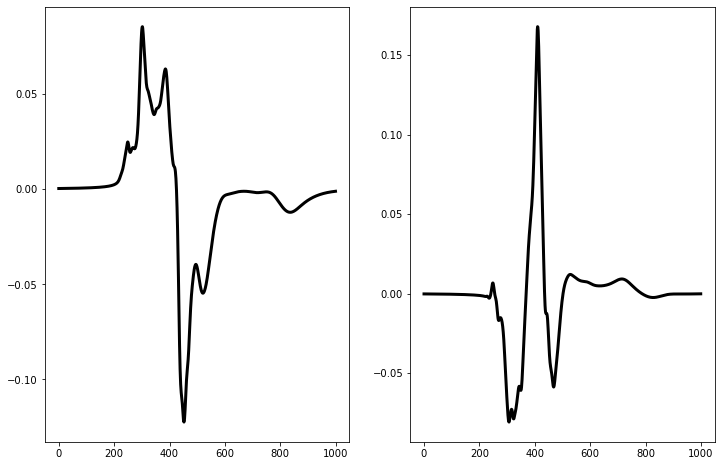

In [28]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

pcs = pca2.components_

for ax, pc in zip(axes, pcs):
    x = np.arange(len(pc))
    ax.plot(x, pc, 'k', linewidth=3)

plt.show()

In [29]:
def make_stacked_scree(xes, xanes, n=20):
    
    xes = xes[:n]
    xanes = xanes[:n]

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1

    ax.plot(x, xes, 's-', markersize=10, fillstyle='none', color=plt.cm.viridis(0.2), label='XES')
    ax.plot(x, xanes, 'o-', markersize=10, color=plt.cm.viridis(0.6), label='XANES')

    plt.xticks(x, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Fraction of Contribution\n(Averaged Over Data)', fontsize=22)
    plt.xlim(0,n+1)
    ax.tick_params(direction='in', width=2, length=8)
    
    plt.legend(fontsize=28)

    plt.show()

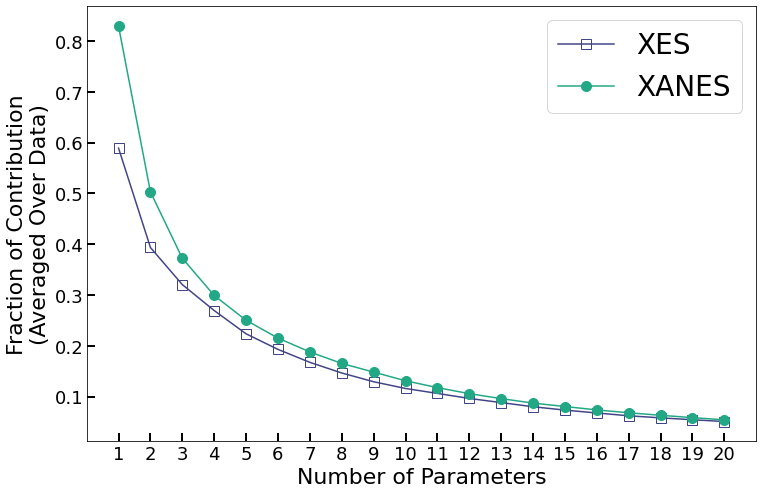

In [30]:
def get_evals(X, n=20):
    
    pca = PCA()
    X_PCA = pca.fit_transform(X)
    
    evals = np.sort(np.abs(X_PCA), axis=1)
    evals = np.flip(evals, axis=1)[:,:n]
    pcs = np.average(evals, axis=0)
    
    return pcs

n = 20
make_stacked_scree(get_evals(XES, n=n), get_evals(XANES, n=n), n=n)